Header

In [17]:
# Import Stuff
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

%matplotlib inline

CSS = """
.output {
    align-items: center;
}
"""

display.HTML('<style>{}</style>'.format(CSS))

def show_state(env, e, t):
    plt.figure(3, figsize=(10, 10))
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: {}, Step: {}".format(e, t))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

n_episodes = 500
gamma = 0.99
epsilon = 0.2
alpha = 0.1

Problem definition

In [18]:
# Fonksiyon parametrelerini olusturalim
# State buyuklugu 4, aksiyon sayisi 2
W = np.zeros((2, 4))

def f(W, s):
    return np.matmul(W, s)

def q(W, s, a):
    return f(W, s)[a]

def dq(W, s, a):
    d = np.zeros_like(W)
    d[a] = s
    return d

def policy(W, s, eps=None):
    if eps:
        nA = W.shape[0]
        if np.random.rand() < eps:
            return np.random.randint(nA)
    return np.argmax(f(W, s))

def run_env(env, W):
    state = env.reset()
    done = False
    t = 0

    while not done:
        t += 1
        show_state(env, 1, t)

        action = policy(W, state)
        next_state, reward, done, info = env.step(action)
        state = next_state

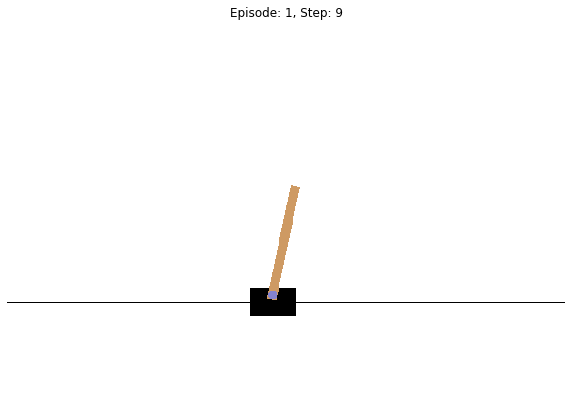

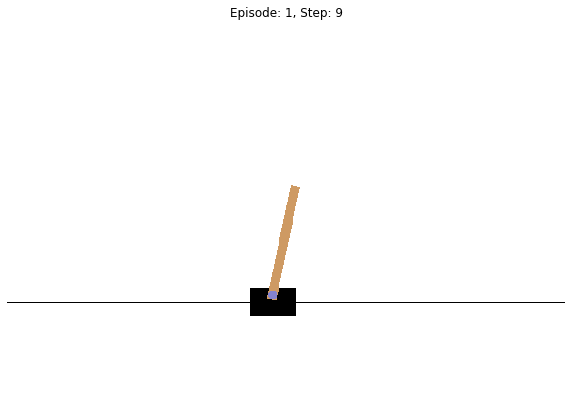

In [19]:
# Egitilmemis
env = gym.make('CartPole-v0')
run_env(env, W)

In [20]:
rewards = []
W = np.zeros((2, 4))

for e in tqdm(range(1, n_episodes+1)):
    state = env.reset()
    done = False
    t = 0
    total_reward = 0
    
    while not done:
        t += 1
        #show_state(env, e, t)
        
        action = policy(W, state, epsilon)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        
        if done:
            W += alpha * (reward - q(W, state, action)) * dq(W, state, action)
        else:
            next_action = policy(W, next_state, epsilon)
            diff = reward - gamma*q(W, next_state, next_action) - q(W, state, action)
            
            W += alpha * diff * dq(W, state, action)
            
        state = next_state
       
    rewards.append(total_reward)
    
    if e % 100 == 0:
        epsilon /= 2.
    
env.close()

100%|██████████| 500/500 [00:00<00:00, 512.51it/s]


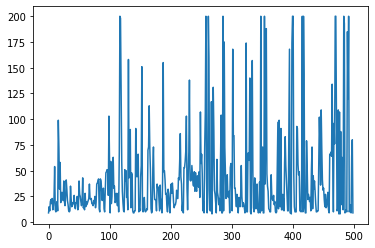

In [21]:
plt.plot(rewards)

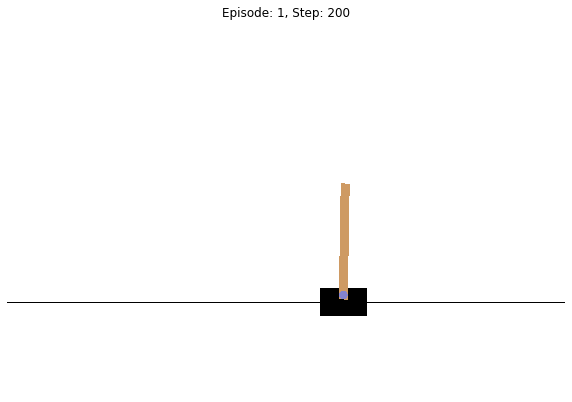

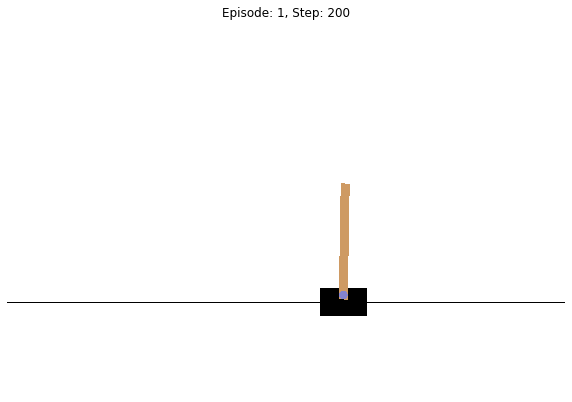

In [9]:
# Egitildikten sonra
run_env(env, W)